In [33]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(digest)
library(reshape2)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)

In [34]:
# reading the dataset from online UCI Machine Learning Repository

temp <- tempfile()
download.file("http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)

head(data)


Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


In [35]:
# Looking at the variables we have
# Seems like the dataset from above is already in Tidy Format! However, 
# some of these variables classified as characters  
glimpse(data)

Rows: 395
Columns: 33
$ school     <chr> "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP"…
$ sex        <chr> "F", "F", "F", "F", "F", "M", "M", "F", "M", "M", "F", "F"…
$ age        <dbl> 18, 17, 15, 15, 16, 16, 16, 17, 15, 15, 15, 15, 15, 15, 15…
$ address    <chr> "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U"…
$ famsize    <chr> "GT3", "GT3", "LE3", "GT3", "GT3", "LE3", "LE3", "GT3", "L…
$ Pstatus    <chr> "A", "T", "T", "T", "T", "T", "T", "A", "A", "T", "T", "T"…
$ Medu       <dbl> 4, 1, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4…
$ Fedu       <dbl> 4, 1, 1, 2, 3, 3, 2, 4, 2, 4, 4, 1, 4, 3, 2, 4, 4, 3, 2, 3…
$ Mjob       <chr> "at_home", "at_home", "at_home", "health", "other", "servi…
$ Fjob       <chr> "teacher", "other", "other", "services", "other", "other",…
$ reason     <chr> "course", "course", "other", "home", "home", "reputation",…
$ guardian   <chr> "mother", "father", "mother", "mother", "father", "mother"…
$ traveltime <dbl> 2, 1, 1, 1,

In [36]:
# Turn discrete variables into factors instead of characters
data <- data %>%
    mutate(across(school:sex, as.factor)) %>%
    mutate(across(address:health, as.factor)) 
glimpse(data)

Rows: 395
Columns: 33
$ school     <fct> GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP, GP…
$ sex        <fct> F, F, F, F, F, M, M, F, M, M, F, F, M, M, M, F, F, F, M, M…
$ age        <dbl> 18, 17, 15, 15, 16, 16, 16, 17, 15, 15, 15, 15, 15, 15, 15…
$ address    <fct> U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U, U…
$ famsize    <fct> GT3, GT3, LE3, GT3, GT3, LE3, LE3, GT3, LE3, GT3, GT3, GT3…
$ Pstatus    <fct> A, T, T, T, T, T, T, A, A, T, T, T, T, T, A, T, T, T, T, T…
$ Medu       <fct> 4, 1, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4…
$ Fedu       <fct> 4, 1, 1, 2, 3, 3, 2, 4, 2, 4, 4, 1, 4, 3, 2, 4, 4, 3, 2, 3…
$ Mjob       <fct> at_home, at_home, at_home, health, other, services, other,…
$ Fjob       <fct> teacher, other, other, services, other, other, other, teac…
$ reason     <fct> course, course, other, home, home, reputation, home, home,…
$ guardian   <fct> mother, father, mother, mother, father, mother, mother, mo…
$ traveltime <fct> 2, 1, 1, 1,

In [37]:
#splitting 75% into training set and 25% into testing set
student_split <- initial_split(data, prop = 3/4, strata = G3)  
student_train <- training(student_split)   
student_test <- testing(student_split)

In [38]:
# See if there are NA's in the training set
# There are no NA's in the training set! 
sum(is.na(student_train))

[1] 0

### Summarizing Data

In [39]:
# Looking at summary statistics for training set
summary(student_train)

 school   sex          age        address famsize   Pstatus Medu   Fedu  
 GP:258   F:152   Min.   :15.00   R: 66   GT3:218   A: 28   0: 3   0: 1  
 MS: 40   M:146   1st Qu.:16.00   U:232   LE3: 80   T:270   1:43   1:61  
                  Median :17.00                             2:76   2:84  
                  Mean   :16.69                             3:78   3:78  
                  3rd Qu.:18.00                             4:98   4:74  
                  Max.   :21.00                                          
       Mjob           Fjob            reason      guardian   traveltime
 at_home : 46   at_home : 16   course    :115   father: 73   1:199     
 health  : 26   health  : 13   home      : 78   mother:202   2: 75     
 other   :100   other   :164   other     : 25   other : 23   3: 17     
 services: 81   services: 83   reputation: 80                4:  7     
 teacher : 45   teacher : 22                                           
                                                  

### Visualizing Data

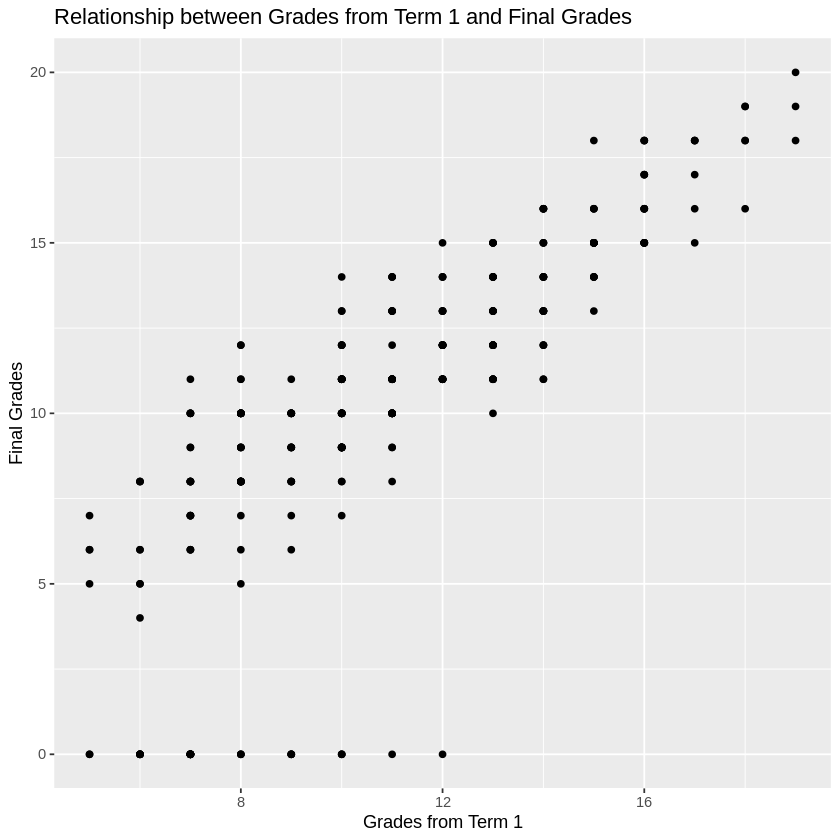

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



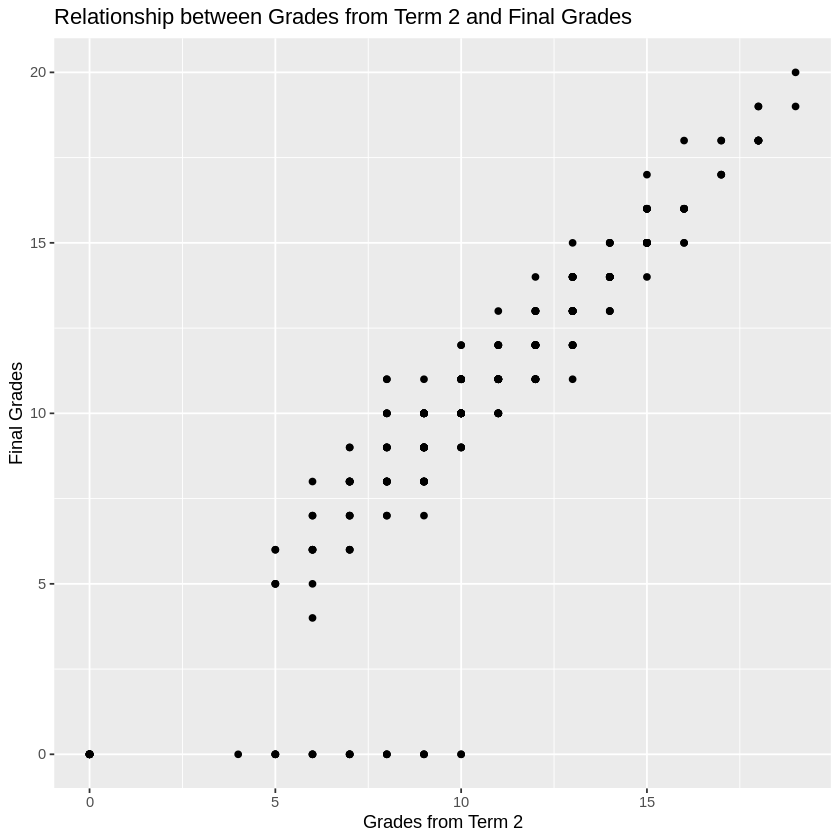

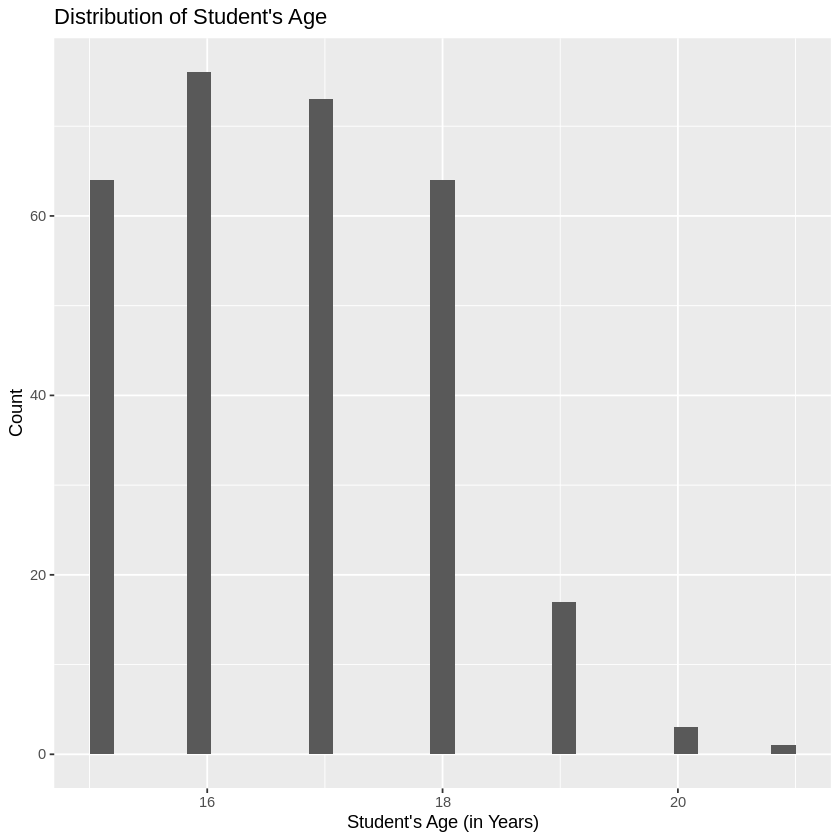

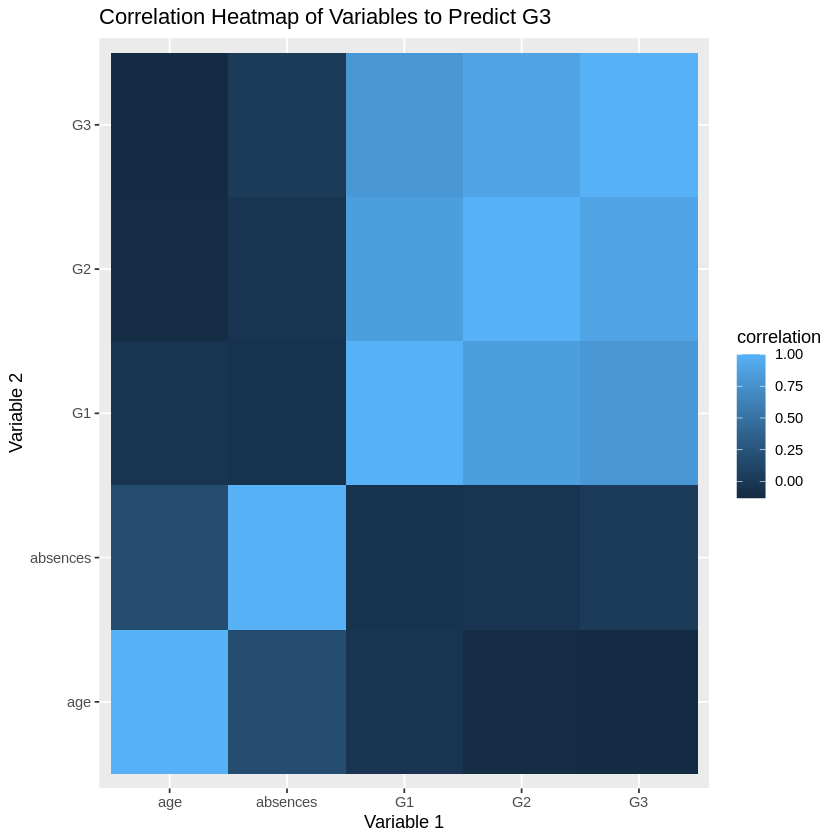

In [40]:
# Visualizing 2 plots with variables that we think will impact final grades, 1 plot about distribution of a variable, and 1 plot about correlation heatmap
G1_G3_plot <- student_train %>%
    ggplot(aes(x = G1, y= G3)) +
    geom_point() +
    labs(x = "Grades from Term 1", y = "Final Grades") + 
    ggtitle("Relationship between Grades from Term 1 and Final Grades")

G2_G3_plot <- student_train %>%
    ggplot(aes(x = G2, y= G3)) +
    geom_point() +
    labs(x = "Grades from Term 2", y = "Final Grades") + 
    ggtitle("Relationship between Grades from Term 2 and Final Grades")

age_plot <- student_train %>%
    ggplot(aes(x = age)) +
    geom_histogram() +
    labs(x = "Student's Age (in Years)", y = "Count") + 
    ggtitle("Distribution of Student's Age")

student_train_select <- student_train %>%
    select(age, absences, G1, G2, G3)

cormat <- round(cor(student_train_select),2)
melted_cormat <- melt(cormat)
corr_plot <- ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
    geom_tile() +
    ggtitle("Correlation Heatmap of Variables to Predict G3") +
    labs(x = "Variable 1", y = "Variable 2", fill = "correlation")

G1_G3_plot
G2_G3_plot
age_plot
corr_plot

### ^^From this correlation graph above, we can see that G1 (grades from term 1) and G2 (grades from term 2) are correlated to final grade. Absences is also slightly correlated.




In [41]:
# Building a linear regression model specification
lm_spec <- linear_reg() %>% 
set_engine("lm") %>%
set_mode("regression") 

lm_spec

Linear Regression Model Specification (regression)

Computational engine: lm 


In [62]:
# Creating a recipe using Age of the students(age) and final grades of the students(G3) as variables of interest using the training dataset.
# Establishing a workflow analysis with the model specification and recipe and fitting our training dataset to the linear regression model.

lm_recipe <- recipe(age ~ G3, data = student_train)

lm_fit <- workflow() %>%
            add_recipe(lm_recipe) %>%
            add_model(lm_spec) %>%
            fit(data = student_train)
lm_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)           G3  
    17.0537      -0.0353  


`geom_smooth()` using formula 'y ~ x'



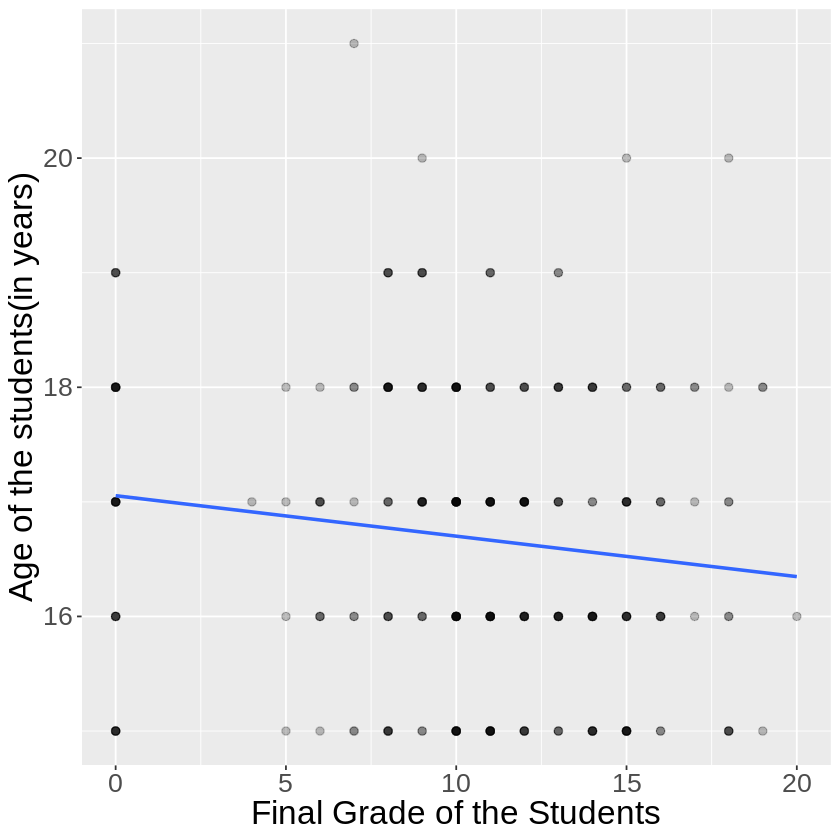

In [63]:
# Visualizing the model predictions as a straight line overlaid on the training data
lm_predictions <- student_train %>%
    ggplot(aes(x = G3, y = age)) +
        geom_point(alpha = 0.25, size = 2) +
        geom_smooth(method = "lm", se = FALSE) +
        xlab("Final Grade of the Students") +
        ylab("Age of the students(in years)") +
        theme(text = element_text(size = 20))

lm_predictions

In [66]:
# Calculating the RMSPE using the test data
lm_test_results <- lm_fit %>%
                    predict(student_test) %>%
                    bind_cols(student_test) %>%
                    metrics(truth = age, estimate = .pred)

lm_rmspe <- lm_test_results %>%
                filter(.metric == 'rmse') %>%
                select(.estimate) %>%
                pull()
lm_rmspe

[1] 1.26679

`geom_smooth()` using formula 'y ~ x'



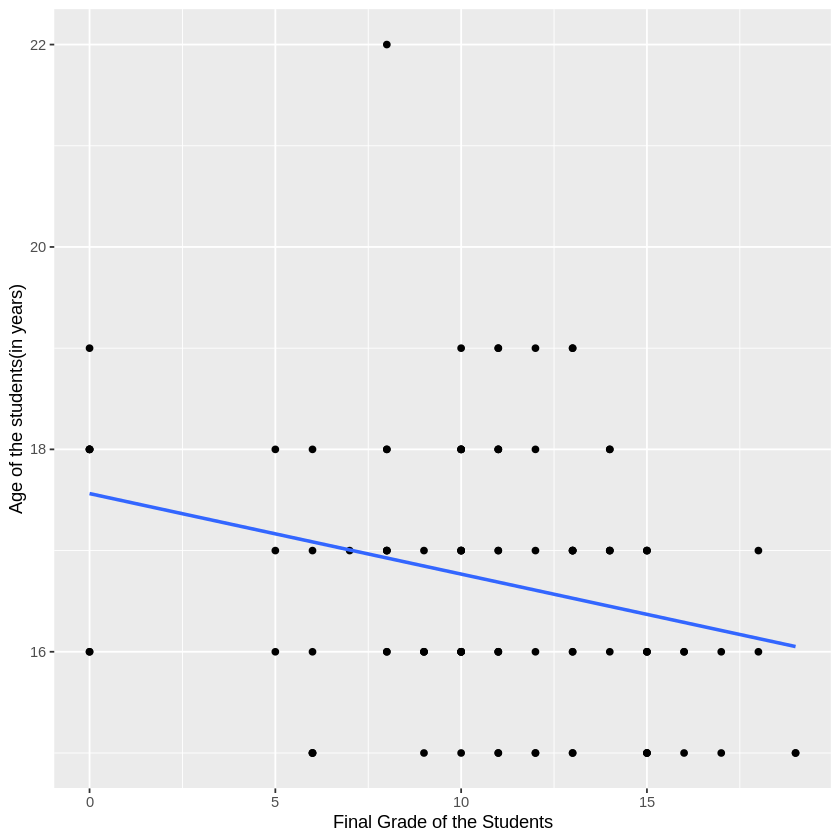

In [69]:
# Visualizing the model predictions as a straight line overlaid on the test data
lm_predictions_test <- student_test %>%
ggplot(aes(x=G3, y=age)) +
geom_point()+
labs(x="Final Grade of the Students", y="Age of the students(in years)")+
geom_smooth(method = "lm", se= FALSE)

lm_predictions_test


In [70]:
# Creating a recipe using final grades of the students(G3) and Term 1 grades of the students(G1) as variables of interest using the training dataset.
# Establishing a workflow analysis with the model specification and recipe and fitting our training dataset to the linear regression model.

lm_recipe_1 <- recipe(G3 ~ G1, data = student_train)

lm_fit_1 <- workflow() %>%
            add_recipe(lm_recipe) %>%
            add_model(lm_spec) %>%
            fit(data = student_train)
lm_fit_1

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)           G3  
    17.0537      -0.0353  


`geom_smooth()` using formula 'y ~ x'



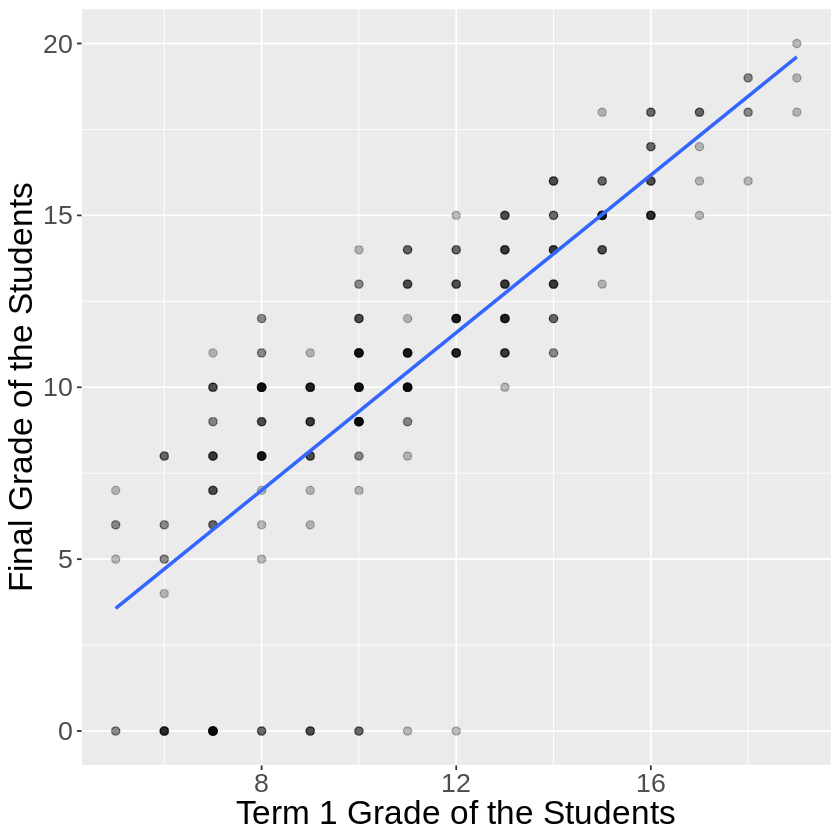

In [73]:
# Visualizing the model predictions as a straight line overlaid on the training data
lm_predictions_1 <- student_train %>%
    ggplot(aes(x = G1, y = G3)) +
        geom_point(alpha = 0.25, size = 2) +
        geom_smooth(method = "lm", se = FALSE) +
        xlab("Term 1 Grade of the Students") +
        ylab("Final Grade of the Students") +
        theme(text = element_text(size = 20))

lm_predictions_1

In [78]:
# Calculating the RMSPE using the test data
lm_test_results_1 <- lm_fit_1 %>%
                    predict(student_test) %>%
                    bind_cols(student_test) %>%
                    metrics(truth = G3, estimate = .pred)

lm_rmspe_1 <- lm_test_results_1 %>%
                filter(.metric == 'rmse') %>%
                select(.estimate) %>%
                pull()
lm_rmspe_1

[1] 7.579082

`geom_smooth()` using formula 'y ~ x'



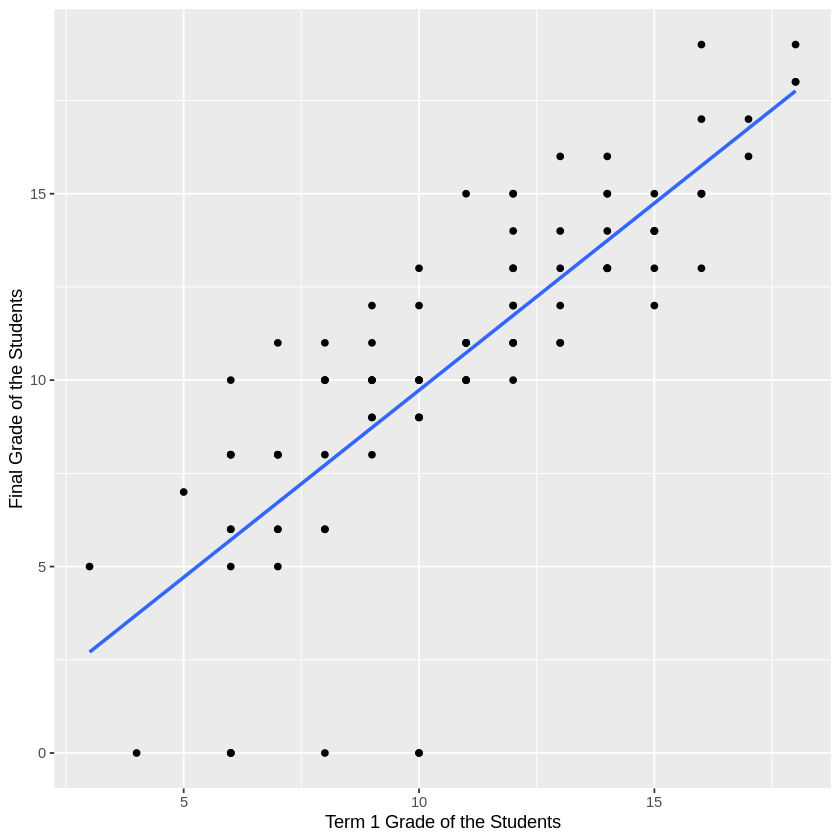

In [79]:
# Visualizing the model predictions as a straight line overlaid on the test data
lm_predictions_test_1 <- student_test %>%
ggplot(aes(x=G1, y=G3)) +
geom_point()+
labs(x="Term 1 Grade of the Students", y="Final Grade of the Students")+
geom_smooth(method = "lm", se= FALSE)

lm_predictions_test_1
